In [3]:
import pandas as pd
import numpy as np
import re

from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from tqdm import tqdm
tqdm.pandas()

In [20]:
df = pd.read_csv('parsed_raw_texts.csv', index_col=0)
df

,name,date,link,text
0,"Театральные премьеры февраля: ""Садко"", ""Чайка""...",2020-02-01 23:46:00,https://ria.ru/20200201/1564150494.html,"МОСКВА, 1 фев – РИА Новости, Наталия Курова. В..."
1,В США прооперировали архиепископа Кипрского,2020-02-01 23:39:00,https://ria.ru/20200201/1564152142.html,"АФИНЫ, 1 фев - РИА Новости. Архиепископ Кипрск..."
2,В Госдуме прокомментировали идею об упоминании...,2020-02-01 23:36:00,https://ria.ru/20200201/1564152109.html,"МОСКВА, 1 фев - РИА Новости. Первый зампред ко..."
3,"В Киеве рассчитывают, что местные выборы на Ук...",2020-02-01 23:27:00,https://ria.ru/20200201/1564152051.html,"КИЕВ, 1 фев - РИА Новости. Помощник президента..."
4,Клишас оценил предложение патриарха об упомина...,2020-02-01 23:26:00,https://ria.ru/20200201/1564152029.html,"МОСКВА, 1 фев - РИА Новости. Предложение об уп..."
...,...,...,...,...
72516,Волков отреагировал на угрозы бойца MMA в адре...,2020-04-30 23:07:00,https://lenta.ru/news/2020/04/30/volkov/,Российский боец UFC Александр Волков в Instagr...
72517,Бабкину выписали из больницы,2020-04-30 23:24:00,https://lenta.ru/news/2020/04/30/babkina_out/,Народную артистку России Надежду Бабкину выпис...
72518,Россию сочли вышедшей на плато по коронавирусу,2020-04-30 23:37:00,https://lenta.ru/news/2020/04/30/plato_rssa/,Россия практически находилась на плато по коли...
72519,Кремль отреагировал на данные о возможном уход...,2020-04-30 23:52:00,https://lenta.ru/news/2020/04/30/kremlin_mish/,Официальный представитель Кремля Дмитрий Песко...


In [31]:
patterns = "[0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()

def lemmatize(doc):
    if type(doc) is not str:
        return None
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and token not in stopwords_ru:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            
            tokens.append(token)
    if len(tokens) > 2:
        return ' '.join(tokens)
    return None

In [21]:
df['text'] = df['name'] + '\n' + df['text']
df['text']

0        Театральные премьеры февраля: "Садко", "Чайка"...
1        В США прооперировали архиепископа Кипрского \n...
2        В Госдуме прокомментировали идею об упоминании...
3        В Киеве рассчитывают, что местные выборы на Ук...
4        Клишас оценил предложение патриарха об упомина...
                               ...                        
72516    Волков отреагировал на угрозы бойца MMA в адре...
72517    Бабкину выписали из больницы\nНародную артистк...
72518    Россию сочли вышедшей на плато по коронавирусу...
72519    Кремль отреагировал на данные о возможном уход...
72520    Российский врач заразил коронавирусом коллег п...
Name: text, Length: 72521, dtype: object

In [34]:
df['text'] = df['text'].progress_apply(lemmatize)
df = df[['date', 'text']]
df

100%|██████████████████████████████████████████████████████████████████████████| 72521/72521 [1:07:52<00:00, 17.81it/s]


,date,text
0,2020-02-01 23:46:00,"[театральный, премьера, февраль, садко, чайка,..."
1,2020-02-01 23:39:00,"[в, сша, прооперировать, архиепископ, кипрский..."
2,2020-02-01 23:36:00,"[в, госдума, прокомментировать, идея, упоминан..."
3,2020-02-01 23:27:00,"[в, киев, рассчитывать, местный, выборы, украи..."
4,2020-02-01 23:26:00,"[клишас, оценить, предложение, патриарх, упоми..."
...,...,...
72516,2020-04-30 23:07:00,"[волков, отреагировать, угроза, боец, mma, адр..."
72517,2020-04-30 23:24:00,"[бабкин, выписать, больница, народный, артистк..."
72518,2020-04-30 23:37:00,"[россия, счесть, выйти, плато, коронавирус, ро..."
72519,2020-04-30 23:52:00,"[кремль, отреагировать, дать, возможный, уход,..."


In [35]:
df.dropna(inplace=True)
df['text'] = df['text'].progress_apply(lambda tokens: ' '.join(tokens))

C:\Users\Andrew\AppData\Local\Temp\ipykernel_11088\3263777464.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)
100%|█████████████████████████████████████████████████████████████████████████| 72331/72331 [00:01<00:00, 64159.34it/s]
C:\Users\Andrew\AppData\Local\Temp\ipykernel_11088\3263777464.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].progress_apply(lambda tokens: ' '.join(tokens))


In [36]:
df.to_csv('processed_texts.csv')

In [1]:
import torch
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny2")
# model.cuda()  # uncomment it if you have a GPU

def embed_bert_cls(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

Downloading:   0%|          | 0.00/112M [00:00<?, ?B/s]

Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


(312,)


In [4]:
df = pd.read_csv('processed_texts.csv', index_col=0)

In [5]:
embed = df['text'].progress_apply(lambda text: embed_bert_cls(text, model, tokenizer))

100%|██████████████████████████████████████████████████████████████████████████| 72331/72331 [1:29:55<00:00, 13.41it/s]


In [22]:
df_embed = pd.merge(df['date'], pd.DataFrame.from_records(embed.values.tolist()), left_index=True, right_index=True)

In [23]:
df_embed.to_csv('embedded_texts.csv')

In [31]:
df_embed.loc[:, 0:]

,0,1,2,3,4,5,6,7,8,9,...,302,303,304,305,306,307,308,309,310,311
0,0.022919,-0.047559,0.028737,-0.017671,-0.014256,-0.112884,0.024105,-0.014891,-0.002527,0.051494,...,-0.006190,0.079312,0.063433,0.048914,-0.056163,0.046185,-0.025104,-0.023257,-0.049136,-0.062671
1,-0.072687,-0.006558,0.039347,-0.023020,-0.018857,-0.020254,0.043719,-0.041217,-0.040680,-0.012799,...,-0.015245,0.082983,0.016379,-0.029849,0.001692,0.002448,-0.025223,0.024272,-0.050296,-0.104275
2,-0.034527,-0.059596,0.061529,-0.069138,-0.060549,0.017503,0.119809,-0.046830,-0.041024,0.070790,...,0.000523,0.012802,0.038572,-0.015614,-0.027195,-0.010929,-0.011893,-0.011793,-0.058530,-0.062553
3,0.054843,0.019388,0.042000,-0.025696,0.009298,0.021045,0.031401,-0.021637,-0.067936,0.046914,...,-0.000067,-0.045189,0.029791,0.080892,0.037885,-0.029931,-0.055936,0.028068,0.048215,-0.083770
4,-0.035553,-0.031173,0.014390,-0.007953,-0.073911,0.034342,0.043338,-0.056792,-0.024377,0.063602,...,0.031636,0.022105,0.081594,0.020133,-0.058844,0.037493,-0.022628,-0.014695,-0.044203,-0.051891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72326,-0.009248,-0.032199,0.012079,-0.080449,-0.017790,-0.048353,0.068755,0.016603,-0.050449,0.052505,...,0.012969,-0.011995,0.042693,0.053481,0.030055,0.001219,-0.059300,0.013203,0.002845,-0.022147
72327,0.023319,0.015737,0.036202,-0.072128,-0.040782,-0.022750,-0.022667,-0.057613,-0.007772,-0.009829,...,0.005766,0.033588,0.047259,0.027924,-0.021063,0.015584,-0.004619,-0.032608,-0.050337,-0.105057
72328,0.061041,-0.025040,0.030916,-0.077484,0.007710,-0.036808,0.051746,-0.020360,-0.063576,0.014742,...,0.034423,0.000976,-0.006401,0.048678,-0.012757,-0.023718,-0.050182,0.004070,-0.018464,-0.090414
72329,-0.023292,-0.015353,0.009452,-0.044053,-0.029657,-0.044287,0.036951,-0.024855,-0.092662,0.031562,...,0.012743,0.038124,0.045285,-0.011348,-0.041659,-0.022094,-0.037040,0.058298,-0.060618,-0.085724


In [32]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2)
low_dim_data = model.fit_transform(df_embed.loc[:, 0:])
print('Lower dim data has shape', low_dim_data.shape)

C:\Users\Andrew\anaconda3\envs\Kono_Dima_da\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Andrew\anaconda3\envs\Kono_Dima_da\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Lower dim data has shape (72141, 2)


In [39]:
df_tsne = pd.merge(df['date'], pd.DataFrame(low_dim_data), left_index=True, right_index=True)
df_tsne.to_csv('embedded_texts_tsne.csv')

In [44]:
df_tsne.head()

,date,0,1
0,2020-02-01 23:46:00,45.094421,-20.544294
1,2020-02-01 23:39:00,14.978184,-44.894489
2,2020-02-01 23:36:00,-14.592736,35.644344
3,2020-02-01 23:27:00,2.457842,35.016964
4,2020-02-01 23:26:00,-21.262184,33.973701


In [54]:
df_tsne['date'] = df['date'].apply(lambda x: pd.Timestamp(x).month)
df_tsne['date']

0        2
1        2
2        2
3        2
4        2
        ..
72136    4
72137    4
72138    4
72139    4
72140    4
Name: date, Length: 71951, dtype: int64

In [63]:
import seaborn as sns

sns.set_style('darkgrid')
sns.set_palette('rocket')
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

%matplotlib inline
import matplotlib as plt
plt.rcParams['figure.figsize'] = (20, 14)
from matplotlib import pyplot as plt

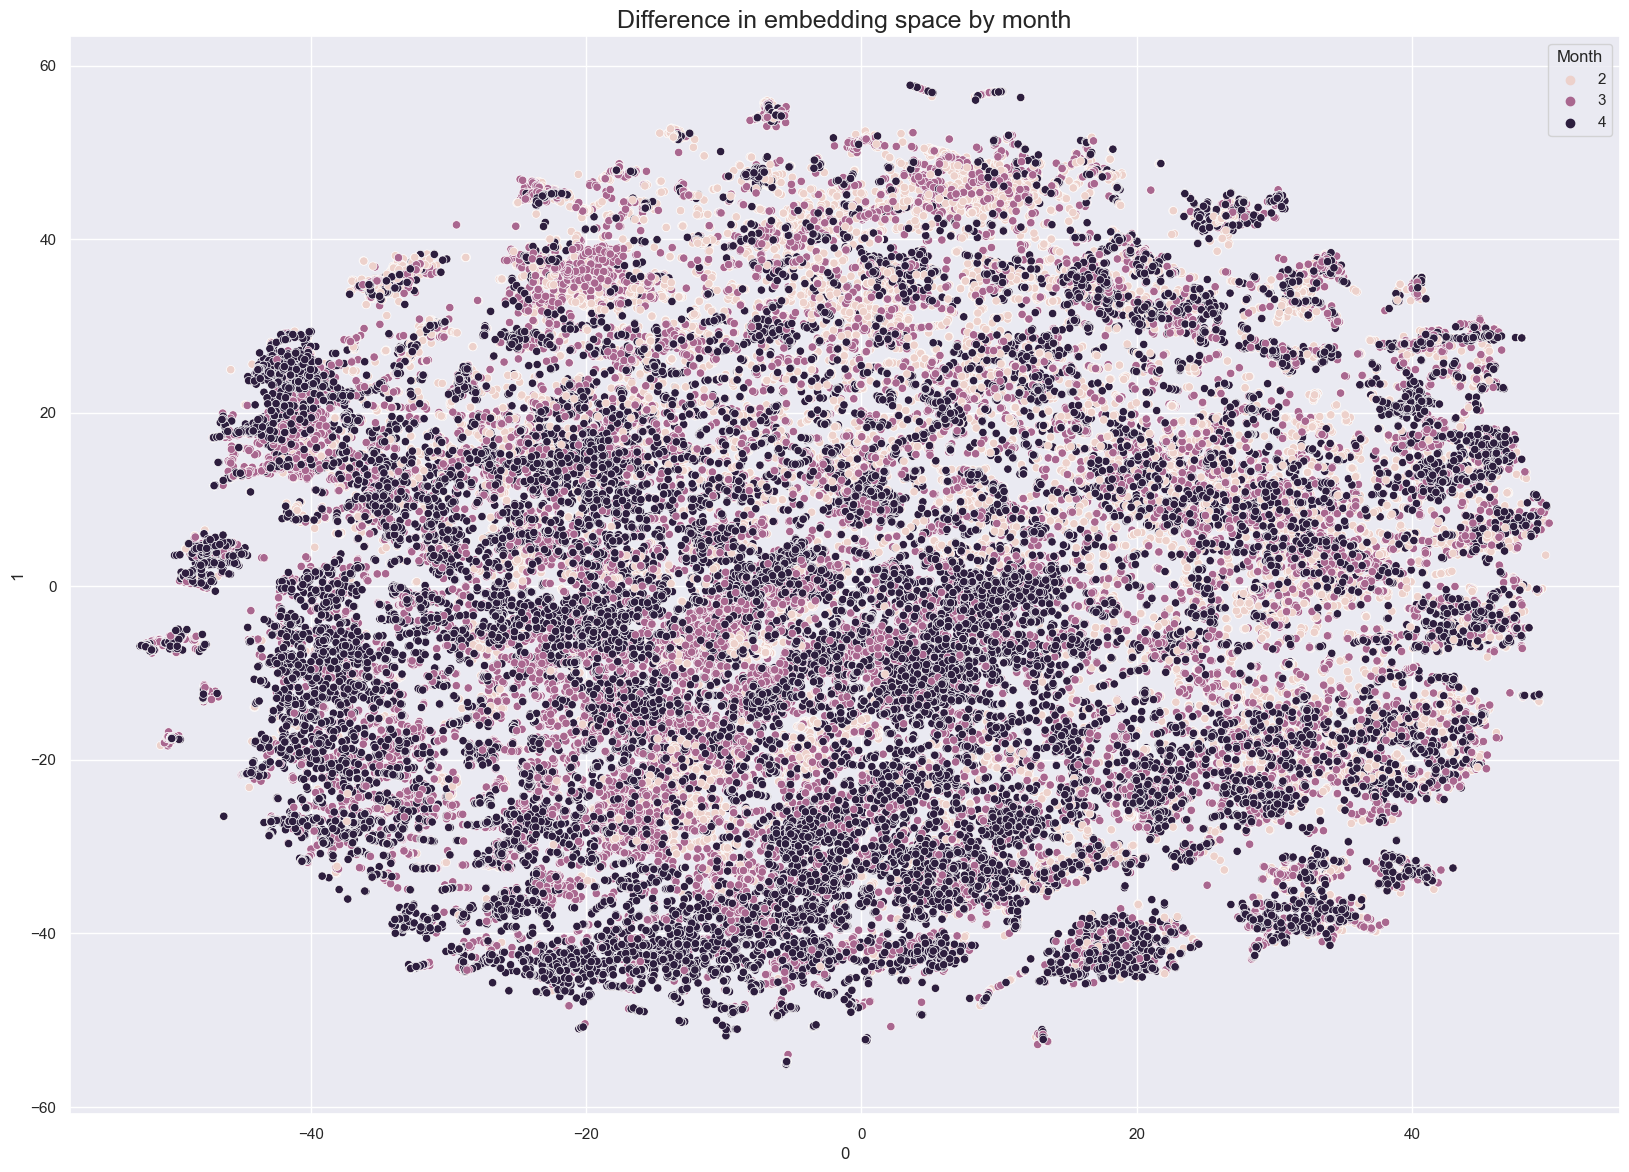

In [70]:
ax = sns.scatterplot(data=df_tsne, x=0, y=1, hue='date')
ax.set_title("Difference in embedding space by month", size=18)
ax.legend(title='Month')